In [2]:
import numpy as np
from matplotlib import pyplot as plt
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Activation, Flatten , Dense
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

Using TensorFlow backend.


# **DATA VISUALIZATION AND PREPROCESSING**

In [3]:
data = pd.read_csv("/kaggle/input/fer2013/fer2013.csv")
data.head()


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [4]:
xtrain, ytrain, xtest, ytest = [], [], [], []
for index, row in data.iterrows():
        img = row['pixels'].split(" ")
        if row['Usage'] == 'Training':
            xtrain.append(img)
            ytrain.append(row['emotion'])
        else:
            xtest.append(img)
            ytest.append(row['emotion'])

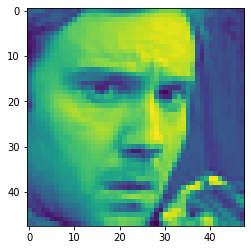

In [5]:
#List to numpy array conversion
xtrain = np.array(xtrain, dtype = 'float32')
xtest = np.array(xtest, dtype = 'float32')
ytrain = np.array(ytrain, dtype = 'float32')
ytest = np.array(ytest, dtype = 'float32')

plt.imshow(xtrain[0].reshape(48, 48))

In [6]:
#Converting to OneHotEncodings
ytrain = np_utils.to_categorical(ytrain, num_classes = 7)
ytest = np_utils.to_categorical(ytest, num_classes = 7)

In [7]:
#Standardizing data and reshaping
ss = StandardScaler()
xtrain = ss.fit_transform(xtrain)
xtest = ss.fit_transform(xtest)
xtrain = xtrain.reshape(xtrain.shape[0], 48, 48, 1)
xtest = xtest.reshape(xtest.shape[0], 48, 48, 1)

# **DEFINING MODEL**

In [8]:
def model():
    model = Sequential()
    
    #1st convolution layer
    model.add(Conv2D(32, kernel_size = (3, 3), activation = 'relu', input_shape = xtrain.shape[1:], kernel_regularizer= regularizers.l2(0.0001)))
    model.add(Conv2D(64, kernel_size = (3, 3), activation = 'relu', kernel_regularizer= regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.2))
    
    #2nd convolution layer
    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', kernel_regularizer= regularizers.l2(0.0001)))
    model.add(Conv2D(128, kernel_size = (3, 3), activation = 'relu', kernel_regularizer= regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size = (2, 2)))
    model.add(Dropout(0.6))
    
    #3rd convolution layer
    model.add(Conv2D(7, kernel_size = (1, 1), activation = 'relu', kernel_regularizer= regularizers.l2(0.0001)))
    model.add(Conv2D(7, kernel_size = (4, 4), activation = 'relu', kernel_regularizer= regularizers.l2(0.0001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    
    model.add(Flatten())
    
    #Fully connected layers
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1024, activation = 'relu'))
    model.add(Dropout(0.4))
    model.add(Dense(7, activation = 'softmax'))
    
    model.summary()
    
    return model

# **TRAINING**

In [9]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = model()
    model.compile(loss = categorical_crossentropy, optimizer = Adam(), metrics = ['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 44, 44, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 128)       73856     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 128)      

In [10]:
#model.load_weights(r"weights.h5")
checkpoint = ModelCheckpoint("best_weights.h5", monitor = 'val_accuracy', verbose = 1, save_best_only = True, mode = 'max')
callbacks_list = [checkpoint]
history = model.fit(xtrain, ytrain, batch_size = 512, initial_epoch = 0, epochs = 150, shuffle = True, verbose = 1, callbacks = callbacks_list, validation_data = (xtest, ytest))

Train on 28709 samples, validate on 7178 samples
Epoch 1/150
28709/28709 [==============================] - 36s 1ms/step - loss: 1.8663 - accuracy: 0.2779 - val_loss: 1.8446 - val_accuracy: 0.2598

Epoch 00001: val_accuracy improved from -inf to 0.25982, saving model to best_weights.h5
Epoch 2/150
28709/28709 [==============================] - 34s 1ms/step - loss: 1.6591 - accuracy: 0.3556 - val_loss: 1.9891 - val_accuracy: 0.1741

Epoch 00002: val_accuracy did not improve from 0.25982
Epoch 3/150
28709/28709 [==============================] - 35s 1ms/step - loss: 1.5739 - accuracy: 0.3946 - val_loss: 2.0622 - val_accuracy: 0.2586

Epoch 00003: val_accuracy did not improve from 0.25982
Epoch 4/150
28709/28709 [==============================] - 35s 1ms/step - loss: 1.5138 - accuracy: 0.4252 - val_loss: 2.0271 - val_accuracy: 0.2705

Epoch 00004: val_accuracy improved from 0.25982 to 0.27055, saving model to best_weights.h5
Epoch 5/150
28709/28709 [==============================] - 34s 1


Epoch 00036: val_accuracy improved from 0.59264 to 0.60337, saving model to best_weights.h5
Epoch 37/150
28709/28709 [==============================] - 35s 1ms/step - loss: 0.9945 - accuracy: 0.6372 - val_loss: 1.1025 - val_accuracy: 0.6042

Epoch 00037: val_accuracy improved from 0.60337 to 0.60421, saving model to best_weights.h5
Epoch 38/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.9927 - accuracy: 0.6401 - val_loss: 1.1389 - val_accuracy: 0.5960

Epoch 00038: val_accuracy did not improve from 0.60421
Epoch 39/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.9893 - accuracy: 0.6393 - val_loss: 1.1271 - val_accuracy: 0.5939

Epoch 00039: val_accuracy did not improve from 0.60421
Epoch 40/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.9776 - accuracy: 0.6457 - val_loss: 1.1463 - val_accuracy: 0.5940

Epoch 00040: val_accuracy did not improve from 0.60421
Epoch 41/150
28709/28709 [========================


Epoch 00074: val_accuracy did not improve from 0.62413
Epoch 75/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.8127 - accuracy: 0.7243 - val_loss: 1.3558 - val_accuracy: 0.5943

Epoch 00075: val_accuracy did not improve from 0.62413
Epoch 76/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.8133 - accuracy: 0.7246 - val_loss: 1.1808 - val_accuracy: 0.6226

Epoch 00076: val_accuracy did not improve from 0.62413
Epoch 77/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.8043 - accuracy: 0.7284 - val_loss: 1.2318 - val_accuracy: 0.6149

Epoch 00077: val_accuracy did not improve from 0.62413
Epoch 78/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.8164 - accuracy: 0.7217 - val_loss: 1.2279 - val_accuracy: 0.6115

Epoch 00078: val_accuracy did not improve from 0.62413
Epoch 79/150
28709/28709 [==============================] - 34s 1ms/step - loss: 0.8189 - accuracy: 0.7255 - val_loss: 1.200

# **RESULTS**

In [24]:
print("Training Accuracy: ", 0.8029)
print("\nFinal Loss & Accuracy: ", model.evaluate(xtest, ytest))
print("\nBest Accuracy: ", 0.62775, "(which is not low because the highest accuracy on the 'fer2013' dataset to-date is 0.65)")

Training Accuracy:  0.8029
7178/7178 [==============================] - 5s 672us/step

Final Loss & Accuracy:  [1.4658013909731313, 0.6199498176574707]

Best Accuracy:  0.62775 (which is not low because the highest accuracy on the 'fer2013' dataset to-date is 0.65)


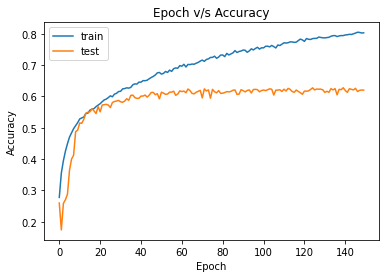

In [19]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Epoch v/s Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(('train', 'test'))
plt.show()

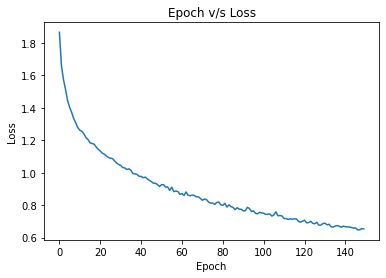

In [20]:
plt.plot(history.history['loss'])
plt.title("Epoch v/s Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [17]:
import os
os.chdir(r'/kaggle/working/')
model.save_weights('final_weights.h5')
model.save('my_model.h5')
fer_json = model.to_json()
with open("archi.json", "w") as json_file:
    json_file.write(fer_json)

In [ ]:
from IPython.display import FileLink
FileLink('my_model.h5')

> # **PREDICITON**

'fear'

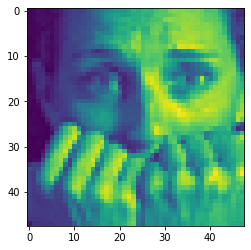

In [88]:
emotion_dict = {0 : 'angry', 1 : 'disgust', 2 : 'fear', 3 : 'happy', 4 : 'sad', 5 : 'surprise', 6 : 'neutral'}
pixels = data["pixels"].loc[np.random.randint(0, data.shape[0] - 1)].split(" ")
test_img = np.array(pixels, dtype = 'float32').reshape(48, 48)
plt.imshow(test_img)
test_img_std = ss.fit_transform(test_img)
emotion_dict[np.argmax(model.predict(test_img_std.reshape(1, 48, 48, 1)))]